 Hi I am Manila Aryal and I am trying to fine tune an already built language model. I first tried to watch some tutorials on how to perform fine tuning on too huge data. Since I was fascinated by the llama 2 model I wanted to perform fine tuning on it and see how it goes.
 Llama 2 is a collection of pretrained and fine-tuned generative text models ranging in scale from 7 billion to 70 billion parameters.I could have accesses the Meta's official llama2 model but I had to apply for a request and wait for their reply to get started. Instead of waiting, I researched that the llama-2-7b-chat-hf model is same as the original and easily accessible.It was little bit modified to include the chatbot functionality in the model.
 For the instructional dataset, I chose a dataset from the huggingface which is named as"amirpoudel/nepal-romanized-restaurant-reviews".This is a small dataset which contains two fields of text and sentiment in which the text contained romanized nepali restaurant reviews and the sentiment was basically 3 values which the text field represented.It is either positive,neutral or negative. The Collab GPU has a limited 16GB of VRAM. This was barely enough to store the llama2-7b's weights,which means full finetuning wasnot possible and The usee of efficient fine tuning techiniques like LORA and QLORA had to be used.

I first watched from videos from the internet to get the concept of LORA and QLORA and basically found that they are used for efficient fine tuning within relatively small GPUs.
When I ran that on the free version of the google collab it was always running out of memory because of the very large base model i.e llama2-chat version. I then purchased the Collab Pro verison but still the Memory provided was not large enough to run on the base model that had 7B parameters.

Therefore, I started researching for little smaller models that were little easy to finetune with the GPI that I was provided but was still suited for the sentiment classification problem. I came across the distilbert-base-uncased model. This is a distilled version of the BERT base model. This model is uncased that means it doesnot make a difference between momo and Momo. This model is primarily aimed at being fine-tuned on tasks that use the whole sentence  to make decisions, such as sequence classification, token classification or question answering. My purpose was to perform sentiment classification so I picked this model to fine tune.  




I started with the installation of the libaries that I would need.

In [ ]:
!pip install evaluate
!pip install --upgrade accelerate
!pip install --upgrade transformers
!pip install torch datasets evaluate


In [ ]:
!pip install transformers[torch]


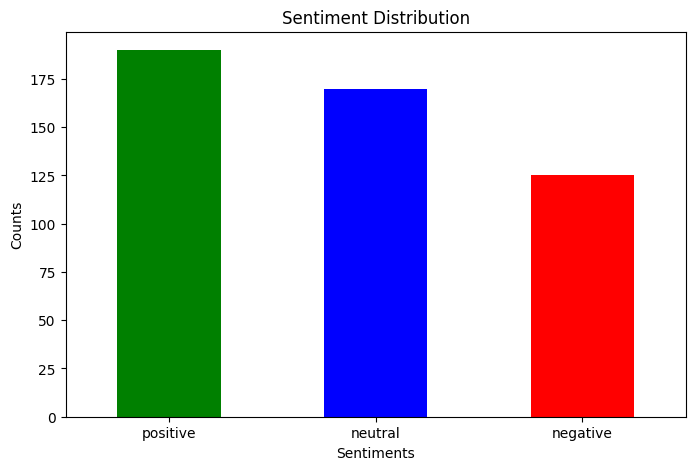

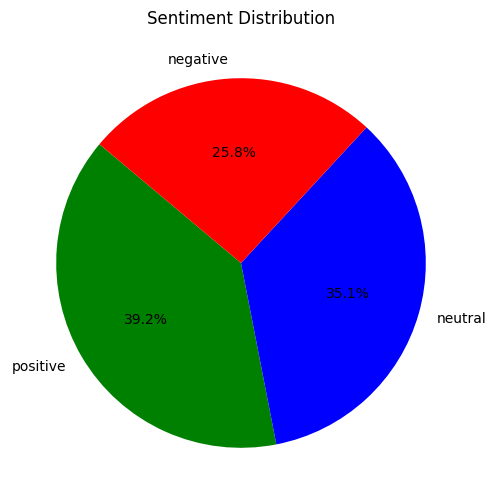

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
# Load the dataset

# Load and preprocess dataset
dataset_name = "amirpoudel/nepal-romanized-restaurant-reviews"
label_map = {"positive": 0, "neutral": 1, "negative": 2}

dataset = load_dataset(dataset_name)

# Split the dataset into train and test if not already split
if "train" not in dataset.keys() or "test" not in dataset.keys():
    dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Process the training and test splits
train_dataset = dataset["train"].map(map_labels)
test_dataset = dataset["test"].map(map_labels)


# Assuming you already have the dataset loaded in a Pandas DataFrame
# Convert your dataset to a DataFrame if not already
df = pd.DataFrame(dataset["train"])  # Replace 'train' with your split if different

# Count sentiment labels
sentiment_counts = df['sentiment'].value_counts()  # Replace 'sentiment' with your column name
sentiment_labels = ['positive', 'neutral', 'negative']

# Bar Graph
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(sentiment_labels)), labels=sentiment_labels, rotation=0)
plt.show()

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=['green', 'blue', 'red']
)
plt.title('Sentiment Distribution')
plt.show()


Here, I first loaded the dataset from Hugginglibrary and started preprocessing it. I also try drawing the bar graph and pie chart to see how the sentiment were distributed along the dataset.
I started with labeling the three sentiments "positive": 0, "neutral": 1, "negative": 2.This was necessary because I learnt that the sentiment labels serve as the target variables for the model during training, enabling it to learn the relationship between input features (e.g., tokenized text) and their corresponding sentiment categories. By converting text labels into integers, the model can calculate loss and update its parameters during training to improve prediction accuracy.
I spilt the dataset into train and test data with the 80:20 ratio for validation purposes.
This transformer library had the Autotokenizer which was super helpful in tokenizing our basemodel.
I then reformatted our train andtest data to the format that the torch would accept for further processing.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import torch
from transformers import BitsAndBytesConfig
import evaluate


def map_labels(example):
    example["label"] = label_map[example["sentiment"]]
    return example

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", trust_remote_code=True)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["text", "sentiment"])
test_dataset = test_dataset.remove_columns(["text", "sentiment"])

# Set format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")





Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Here I load the sentiment classification model using the distilbert-base-uncased pretrained transformer. The model is configured with three output labels (positive, neutral, negative) for sentiment analysis. Training parameters are specified, including learning rate, batch size, number of epochs, and mixed precision (fp16) to optimize GPU memory usage. Metrics are defined using the evaluate library, specifically accuracy, calculated by comparing model predictions to true labels. The Trainer class handles training, evaluation, and logging, with options to save the best-performing model and use it for evaluation. Tokenized datasets (train_dataset and test_dataset) are provided for training and testing. I first ran themodel into 2 epochs which gave me less than 80% accuracy. I tried increasing the epochs and I see that is it not increasing significantly after 3 epochs.

Since the model was not that big as llama2 I didnt have to use efficient parameter tuning methods like LORA and QLORA.

In [ ]:
# Load base model for sentiment classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,  # Sentiment classes: positive, neutral, negative
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Reduced batch size to fit in GPU memory
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,  # Enable mixed precision for memory efficiency
)

# Define metrics for evaluation
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions.numpy(), references=labels)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-1c6152592fbf>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


This step would require you to login into weights and baises and then copy and paste the API key form my profile .

In [ ]:
# Train the model
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy
1,0.913200,0.724416,0.704918
2,0.633200,0.516605,0.827869
3,0.321900,0.559711,0.819672
4,0.264000,0.664008,0.827869
5,0.181700,0.708703,0.827869
6,0.097800,0.732587,0.819672


TrainOutput(global_step=732, training_loss=0.4273332474661655, metrics={'train_runtime': 49.5767, 'train_samples_per_second': 58.697, 'train_steps_per_second': 14.765, 'total_flos': 96371751144960.0, 'train_loss': 0.4273332474661655, 'epoch': 6.0})

The evaluation of the model with the test data also gave around 81% accuracy.

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.5166053175926208,
 'eval_accuracy': 0.8278688524590164,
 'eval_runtime': 0.295,
 'eval_samples_per_second': 413.509,
 'eval_steps_per_second': 105.072,
 'epoch': 6.0}

In [ ]:
def predict_sentiment(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(trainer.model.device) for key, value in inputs.items()}  # Send to GPU/CPU

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Map predictions to labels
    labels = {0: "positive", 1: "neutral", 2: "negative"}
    return [labels[pred.item()] for pred in predictions]

# Test the model on new texts
new_texts = [
    "Yo place ma chai lunch time ma najanus, dherai wait garnu parcha."
]
predictions = predict_sentiment(new_texts)
for text, sentiment in zip(new_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 30)


Text: Yo place ma chai lunch time ma najanus, dherai wait garnu parcha.
Predicted Sentiment: negative
------------------------------


Here I first defined a function for sentiment prediction and provided a sample text and analyzed the results. The text is in Romanized Nepali language . The sample text "Khana and Curry duitai dherai mitho thyo. Ma pheri pani aauchu." that means "The food and curry both were very tasty. I will be coming back" and this is predicting the sentiment to be positive. It is predicting correct in this case. I tried with other negative sentiment texts too. It was also predicting correct for most of the negative cases. For the sentences with words that were rarely present in the dataset it was giving the neutral sentiment even though the sentiment was negative.

In [ ]:
from sklearn.metrics import classification_report

# Get predictions and true labels from the trainer
predictions = trainer.predict(test_dataset)
predicted_classes = predictions.predictions.argmax(axis=-1)  # Predicted labels
true_labels = predictions.label_ids  # True labels

# Generate a classification report
target_names = ["positive", "neutral", "negative"]
print(classification_report(true_labels, predicted_classes, target_names=target_names))


              precision    recall  f1-score   support

    positive       0.82      0.86      0.84        49
     neutral       0.81      0.84      0.83        31
    negative       0.85      0.79      0.81        42

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122



The dataset 'amirpoudel/nepal-romanized-restaurant-reviews' from huggingface has total of 607 rows. The training set contains 485 rows and test set contains 122 rows of sample text along with their sentiment. Among them the classification report shows that the model is working great on positive sentiment texts and it is performing the lowest on negative datasets. Neutral sentiment text also has f1 score of 0.83 which is pretty good for this small dataset. Although this was the dataset of romanized nepali texts some english words like "tasty, good, attractive, attentive " were used which basically gives the sentiment of positive reviews. This would have also helped the model to learn since the dataset was tokenized and trained. This was fun working on the language of your country to build an NLP model using the dataset. Non-nepali people now can undersatnd the sentiment of restaurant reviews of nepali people using this model. It would also be better if the dataset was large so that the model was able to predict sentiments better.   

References:

1. Naik, Krish‬. (2019). Google Colab. Google.com. https://colab.research.google.com/drive/1ccFtdghEg_g9Yu-h7K0PgOmqq12jimFf#scrollTo=5lYYzhCRov5y

2. Sanh, Victor, et al. “DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter.” ArXiv.org, 2019, arxiv.org/abs/1910.01108.
3.Poudel, Amir. “Amirpoudel/Nepal-Romanized-Restaurant-Reviews · Datasets at Hugging Face.” Huggingface.co, 2024, huggingface.co/datasets/amirpoudel/nepal-romanized-restaurant-reviews/viewer/default/train?p=6. Accessed 23 Nov. 2024.
4. Distilbert-Base-Uncased · Hugging Face.” Huggingface.co, huggingface.co/distilbert-base-uncased.
5. “Fine-Tune a Pretrained Model.” Huggingface.co, huggingface.co/docs/transformers/training.